## GeNet: Deep Representations for Bacteria taxonomic classification of metagenomic data

---

Currently, state-of-the-art methods such as Centrifuge (Kim
et al., 2016) and Kraken (Wood & Salzberg, 2014) rely on
sequence alignment, and match each read against a large
database of known genomes. This requires high amounts of
memory for storing such databases, and becomes challenging as the amount of noise in the reads increases.

 Machine learning systems, on the other hand,
can learn from the noise distribution of the input reads.
Moreover, a classification model learns a mapping from
input read to class probabilities, and thus does not require
a database at run-time. Finally, machine learning systems
provide representations of DNA sequences which can be
leveraged for downstream tasks.

Living things can be classified into five major kingdoms:
* Kingdom Animalia
* Kingdom Plantae
* Kingdom Fungi
* Kingdom Protista
* Kingdom Monera (Bacteria)

Every organism is classified by taxanomy represented as (Kingom, Phylum, Class, Order, Family, Genus, Species)

In this notebook i am using the trained models for each part of taxa which takes the DNA sequence(read) as a input predict the particular part of taxanomy and at the end i will concate the output of each as a predict output for whole taxanomy.


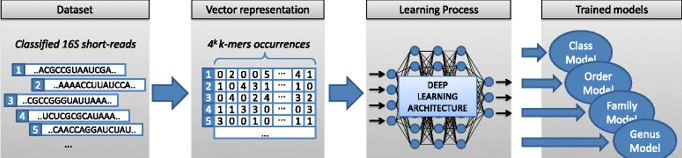

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/Metagenomics/Images/genet.png',height=250,width=800)

In [1]:
import torch, gc
import math
import numpy as np
import pandas as pd
import pickle as pkl

gc.collect()
torch.cuda.empty_cache()

use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Data Collection

I collected the data for Bacteria from  https://github.com/marcomeola/DAIRYdb

# Data Preprocessing

In [2]:
from torchvision import datasets, transforms

path='/content/drive/My Drive/Metagenomics/Bacteria/'

data=pd.read_csv(path+"data.csv")
taxa=['name','Kingdom','Phylum','Class','Order','Family','Genus','Species']
target={}
for i in taxa:
   target[i]=data[i]
feature_read=data['read']
print("Number of rows in a dataset: ",len(feature_read))

Number of rows in a dataset:  875


In [3]:
classes={}
for i in taxa:
  classes[i]= sorted(set(target[i]))

class_dict={}
for i in taxa:
    class_dict[i]={y:x for x,y in enumerate(classes[i])}
class_dict

{'Class': {'Acidimicrobiia': 0,
  'Acidobacteria': 1,
  'Alphaproteobacteria': 2,
  'Bacteroidia': 3,
  'Clostridia': 4,
  'Coriobacteriia': 5,
  'Erysipelotrichia': 6,
  'Gammaproteobacteria': 7,
  'Gemmatimonadetes': 8,
  'Holophagae': 9,
  'Parcubacteria_Class': 10,
  'Saccharibacteria_Class': 11,
  'Solibacteres': 12},
 'Family': {'Acidimicrobiaceae': 0,
  'Acidobacteriaceae': 1,
  'Christensenellaceae': 2,
  'Clostridiales_Family': 3,
  'Clostridiales_vadinBB60_group': 4,
  'Coriobacteriaceae': 5,
  'Ectothiorhodospiraceae': 6,
  'Erysipelotrichaceae': 7,
  'Gemmatimonadaceae': 8,
  'Holophagaceae': 9,
  'Lachnospiraceae': 10,
  'Parcubacteria_Family': 11,
  'Porphyromonadaceae': 12,
  'Prevotellaceae': 13,
  'Rhodospirillaceae': 14,
  'Rikenellaceae': 15,
  'Ruminococcaceae': 16,
  'Saccharibacteria_Family': 17,
  'Solibacteraceae': 18},
 'Genus': {'Acidipila': 0,
  'Aciditerrimonas': 1,
  'Anaerobacterium': 2,
  'Barnesiella': 3,
  'Catenisphaera': 4,
  'Christensenellaceae_R-7_

In [4]:
test_data=pd.read_csv(path+"data.csv")

In [5]:
test_target={}
for i in taxa:
    test_target[i]=test_data[i]
test_feature=test_data['read']

# DNA read character encoding

In [6]:
sets= {'A','C','G','T','U','W','S','M','K','R','Y','B','D','H','V','N','Z'}
char=sorted(sets)
char_encode={y:x+1 for x,y in enumerate(char)}
char_encode

{'A': 1,
 'B': 2,
 'C': 3,
 'D': 4,
 'G': 5,
 'H': 6,
 'K': 7,
 'M': 8,
 'N': 9,
 'R': 10,
 'S': 11,
 'T': 12,
 'U': 13,
 'V': 14,
 'W': 15,
 'Y': 16,
 'Z': 17}

In [ ]:
read= feature_read[0]
read

'GATGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAGCGGAGTTTAACTGGAAGCACTTGTGCGACCGGATAAACTTAGCGGCGGACGGGTGAGTAACACGTGAGCAACCTACCTATCGCAGGGGAACAACATTGGGAAACCAGTGCTAATACCGCATAACATCTTTTGGGGGCATCCCCGGAAGATCAAAGGATTTCGATCCGGCGACAGATGGGCTCGCGTCCGATTAGCTAGTTGGTAAGGTAAAAGCTTACCAAGGCAACGATCGGTAGCCGAACTGAGAGGTTGATCGGCCACATTGGGACTGAGACACGGCCCAGGCTCCTACGGGAGGCAGCAGTGGGGAATATTGGGCAATGGGGGAAACCCTGACCCAGCAACGCCGCGTGAAGGAAGAAGGCCTTCGGGTTGTAAACTTCTTTGATCAGGGACGAAACAAATGACGGTACCTGAAGAACAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGACAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGTTTCGTAAGTTGGATGTGAAATTCTCAGGCTTAACCTGAGAGGGTCATCCAAAACTGCAAAACTTGAGTACTGGAGAGGATAGTGGAATTCCTAGTGTAGCGGTAAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGACTATCTGGACAGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGAATACTAGGTGTAGGGGGTATCGACCCCCCCTGTGCCGCAGCTAACGCAATAAGTATTCCACCTGGGGAGTACGACCGCAAGGTTGAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCAGTGGAGTATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGGCTTGACATCCTCTGACGGCTGTAGAGATACAGCTTTCCCTTCGGG

In [ ]:
matrix = np.zeros(1650)
for x,y in enumerate(read):
      matrix[x] = char_encode[y]
matrix = matrix.reshape(33,50)
matrix = matrix/20
matrix

array([[0.25, 0.05, 0.6 , ..., 0.05, 0.05, 0.15],
       [0.6 , 0.25, 0.25, ..., 0.05, 0.05, 0.15],
       [0.05, 0.15, 0.25, ..., 0.25, 0.15, 0.6 ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

# Storing the target and encoded feature in pickle format

In [8]:
from collections import defaultdict

path='/content/drive/My Drive/Metagenomics/Bacteria/'

test_path1 = path + 'test_input.pkl'
test_path2 = path + 'test_target.pkl'

test_file1 = open(test_path1, 'wb')
test_file2 = open(test_path2, 'wb')

def f(feature,target,file1,file2):
  lst1=[]
  lst2= defaultdict(list)
  save=True
  if save:
    for i,j in enumerate(feature):
      read=np.zeros(1650)
      for x,y in enumerate(j):
            read[x]=char_encode[y]
      read=read.reshape(33,50)
      lst1.append(read/20)
      for k in taxa:
         lst2[k].append(np.array([class_dict[k][target[k][i]]]))
  pkl.dump(lst1,file1)
  pkl.dump(lst2,file2)
  file1.close()
  file2.close()

f(test_feature,test_target,test_file1,test_file2)

# Preparing Data Loaders

In [7]:
from torch.utils.data import TensorDataset, DataLoader

num_workers=0
batch_size = 20

test_path1 = path + 'test_input.pkl'
test_path2 = path + 'test_target.pkl'

test_file1 = open(test_path1, 'rb')
test_file2 = open(test_path2, 'rb')


test_input = pkl.load(test_file1)
test_target = pkl.load(test_file2)

test_x = torch.Tensor(test_input)
test_y={}
for i in taxa:
    test_y[i] = torch.Tensor(test_target[i])

test_file1.close()
test_file2.close()

test_dataset={}
for i in taxa:
     test_dataset[i] = TensorDataset(test_x,test_y[i].long())

test_loader={}
for i in taxa:
     test_loader[i] = DataLoader(test_dataset[i],batch_size=batch_size)

loaders = {
    'test': test_loader
}

In [ ]:
dataiter={}
for i in taxa:
    dataiter[i] = iter(test_loader[i])

labels=[]
for i in taxa:
   images, label = dataiter[i].next()
   labels.append(label)
print("Images: ",images,"Labels: ",labels)

Images:  tensor([[[0.2500, 0.0500, 0.6000,  ..., 0.0500, 0.0500, 0.1500],
         [0.6000, 0.2500, 0.2500,  ..., 0.0500, 0.0500, 0.1500],
         [0.0500, 0.1500, 0.2500,  ..., 0.2500, 0.1500, 0.6000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.2500, 0.0500, 0.6000,  ..., 0.1500, 0.6000, 0.1500],
         [0.2500, 0.2500, 0.0500,  ..., 0.1500, 0.2500, 0.6000],
         [0.2500, 0.0500, 0.2500,  ..., 0.0500, 0.6000, 0.0500],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.1500],
         [0.2500, 0.2500, 0.1500,  ..., 0.2500, 0.1500, 0.6000],
         [0.6000, 0.6000, 0.1500,  ..., 0.6000, 0

# Resnet Blocks

Residual blocks are basically a special case of highway networks without any gates in their skip connections. Essentially, residual blocks allows the flow of memory (or information) from initial layers to last layers.

Residual connections are the same thing as 'skip connections'. They are used to allow gradients to flow through a network directly, without passing through non-linear activation functions

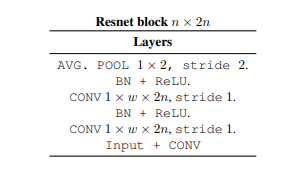

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/Metagenomics/Images/resnet.png',height=250,width=500)

# GeNet model architecture
GeNet, a model for metagenomic classification based on convolutional neural networks. GeNet is
trained end-to-end from raw DNA sequences using standard backpropagation with cross-entropy loss.

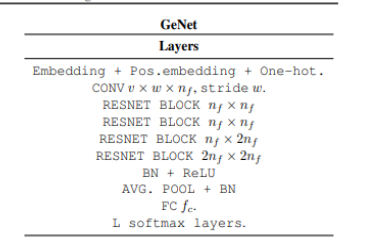

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/Metagenomics/Images/genet_layer.png',height=250,width=500)

In [8]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [9]:
# helper avg_pool function
def pool(out_channels,kernel_size=2, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    pool_layer = nn.AvgPool2d(kernel_size, stride, padding)
    layers.append(pool_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim,nf1=1,nf2=1):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_dim_rslv_layer = conv(in_channels=conv_dim*nf1, out_channels=conv_dim*nf2, 
                                kernel_size= 3, stride=1, padding=1)
        self.conv_layer1 = conv(in_channels=conv_dim*nf1, out_channels=conv_dim*nf2, 
                                kernel_size= 3, stride=1, padding=1,batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim*nf2, out_channels=conv_dim*nf2, 
                               kernel_size= 3, stride=1, padding=1)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x)) 
        y= self.conv_layer2(out_1)
        if x.size()[1]!=y.size()[1]:
           x= self.conv_dim_rslv_layer(x)
        out_2 = x + y
        return out_2
    

In [11]:
class  GeNet(nn.Module):
    
    def __init__(self, conv_dim=128, n_res_blocks=4):
        super(GeNet, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(1, conv_dim, 4)
      
        self.avg_pool = pool(2*conv_dim,kernel_size=[2,1],stride=[2,1],padding=0)
        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []

        res_layers.append(pool(conv_dim))
        res_layers.append(ResidualBlock(conv_dim))
        
        res_layers.append(pool(conv_dim))
        res_layers.append(ResidualBlock(conv_dim))
        
        res_layers.append(pool(conv_dim))
        res_layers.append(ResidualBlock(conv_dim,nf2=2))

        res_layers.append(pool(2*conv_dim))
        res_layers.append(ResidualBlock(conv_dim,nf1=2,nf2=2))

        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)
        
        fc_layers=[]
        # fully-connected
        fc_layers.append(nn.Linear(768,384))
        fc_layers.append(nn.Dropout2d(p=0.20))
        fc_layers.append(nn.ReLU())
        fc_layers.append(nn.Linear(384,768))
        fc_layers.append(nn.Dropout2d(p=0.20))
        fc_layers.append(nn.ReLU())
        fc_layers.append(nn.Linear(768,total_classes))

        # use sequential to create these layers
        self.fc = nn.Sequential(*fc_layers)


         # drop-out
        self.drop_out= nn.Dropout2d(p=0.20)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.drop_out(self.res_blocks(out)))
        out = self.avg_pool(out)

         # Flatten
        out = out.view(-1, 768)
        
        # tanh applied to last layer
        out = self.fc(out)
        return F.log_softmax(out, dim=1)

# instantiate the CNN
models={}
for i in taxa:
   if i=='Kingdom':
        total_classes=len(classes[i])+1
   else:
        total_classes=len(classes[i])
   models[i] = GeNet()

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move tensors to GPU if CUDA is available
if use_cuda:
   for i in models:
    models[i].cuda()

In [20]:
# Do not uncomment this cell but add this
from collections import OrderedDict

model_transfer = {}
for i in taxa:
    if i=='Kingdom':
        total_classes=len(classes[i])+1
    else:
        total_classes=len(classes[i])
    model_transfer[i] = GeNet() 

    layers= OrderedDict()
    mod = list(model_transfer[i].fc.children())
    mod[-1]=nn.Linear(768,384)
    mod.append(nn.Dropout2d(p=0.40))
    mod.append(nn.ReLU())
    mod.append(nn.Linear(384,192))
    mod.append(nn.Dropout2d(p=0.40))
    mod.append(nn.ReLU())
    mod.append(nn.Linear(192,total_classes))

    layer=['fc','drop_out','relu']
    c=0
    while len(mod)!=1:
        for j,k in zip(layer,mod):
            layers[j+str(c)]=k
        c+=1
        mod=mod[3:]
    else:
        layers['fc'+str(c)]=mod[-1]

    new_fc = nn.Sequential(layers)
    model_transfer[i].fc=new_fc
    model_transfer[i].fc

In [25]:
for i in taxa:
   print(i+" model")
   model_transfer[i].load_state_dict(torch.load(path+i.capitalize()+'/'+f'bacteria_{i.lower()}.pt'))
   
# move tensors to GPU if CUDA is available
if use_cuda:
   for i in model_transfer:
       model_transfer[i].cuda()

name model
Kingdom model
Phylum model
Class model
Order model
Family model
Genus model
Species model


In [43]:
model_transfer['name'].parameters

<bound method Module.parameters of GeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (avg_pool): Sequential(
    (0): AvgPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=1)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv_dim_rslv_layer): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv_layer1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_layer2): Sequential(
        (0): Conv2d(128, 128

# Testing the models

In [13]:
import torch.optim as optim

loaders_transfer = loaders
criterion_transfer = nn.CrossEntropyLoss()

In [14]:
def test(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    
    correct = 0.
    test_loss = 0.
    pred_taxas=[]
    for i in taxa:
       total = 0.
       m_correct = 0.
       m_test_loss = 0. 
       model[i].eval()
       pred_taxa=[]
       for batch_idx, (data, target) in enumerate(loader['test'][i]):
          # move to GPU
          if use_cuda:
              data, target = data.cuda(), target.cuda()
          # forward pass: compute predicted outputs by passing inputs to the model
          data = data.unsqueeze(1)
          output = model[i](data)
          target = target.squeeze(1)
          
          # calculate the loss
          loss = criterion(output, target)

          # update average test loss 
          test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
          m_test_loss = m_test_loss + ((1 / (batch_idx + 1)) * (loss.data - m_test_loss))
          # convert output probabilities to predicted class
          pred = output.data.max(1, keepdim=True)[1]
          
          # compare predictions to true label
          pred_taxa+=list(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
          total += data.size(0)
          
          # compare predictions to true label of particular model
          m_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
       
       print(i+' model ->')
       print('Test Loss: {:.6f}'.format(m_test_loss))

       print('Test Accuracy: %2d%% (%2d/%2d)\n' % (
        100. * m_correct / total, m_correct, total))
       pred_taxas.append(pred_taxa)

    for i in zip(*pred_taxas): 
        correct += all(i)
              
    print('Overall Test Loss: {:.6f}\n'.format(test_loss/len(taxa)))
    print('\nOverall Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [27]:
# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

name model ->
Test Loss: 0.696922
Test Accuracy: 83% (727/875)

Kingdom model ->
Test Loss: 0.270110
Test Accuracy: 100% (875/875)

Phylum model ->
Test Loss: 1.316758
Test Accuracy: 56% (491/875)

Class model ->
Test Loss: 1.298235
Test Accuracy: 61% (540/875)

Order model ->
Test Loss: 1.261903
Test Accuracy: 61% (534/875)

Family model ->
Test Loss: 1.035533
Test Accuracy: 70% (621/875)

Genus model ->
Test Loss: 1.306244
Test Accuracy: 73% (640/875)

Species model ->
Test Loss: 0.851094
Test Accuracy: 79% (694/875)

Overall Test Loss: 0.106387


Overall Accuracy: 28% (250/875)


# Running Inference on models

In [ ]:
# instantiate the CNN
taxa=['name','Kingdom','Phylum','Class','Order','Family','Genus','Species']
models={}
for i in taxa:
   if i=='Kingdom':
        total_classes=len(classes[i])+1
   else:
        total_classes=len(classes[i])
   models[i] = GeNet()

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move tensors to GPU if CUDA is available
if use_cuda:
   for i in models:
    models[i].cuda()
    
for i in taxa:
   models[i].load_state_dict(torch.load(path+i.capitalize()+'/'+f'bacteria_{i.lower()}.pt'))


In [ ]:
###  a function that takes a path to a read as input
### and returns the taxanomy as kingdom that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = classes

def predict_taxa_transfer(seq):
    
    # load the read and return the predicted taxa
    input=0
    
    read=np.zeros(2500)
    for x,y in enumerate(seq):
        read[x]=char_encode[y]
    read=read.reshape(50,50)
    input=read/20

    tensor_r = torch.Tensor(input).unsqueeze(0).unsqueeze(0)

    if use_cuda:
        tensor_r = tensor_r.cuda()

    taxas=[]
    for i in taxa:
       models[i].eval()
       output= models[i](tensor_r)

       # convert output probabilities to predicted class
       _, pred_tensor=torch.max(output, 1)
       index = np.squeeze(pred_tensor.numpy()) if not use_cuda else np.squeeze(pred_tensor.cpu().numpy())
       taxas.append(class_names[i][index])
    return taxas

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
df = pd.DataFrame()
def run_app(seq,taxas):
      cls=['Classification','Name','Kingdom','Phylum','Class','Order','Family','Genus','Species']
      dct={}
      prediction = predict_taxa_transfer(seq)
      classify=[['Correct']+taxas,['Predicted']+prediction]
      global df
      for i in classify:
         for k,j in zip(cls,i):
           dct[k]=j
         dct['Input']=seq
         df=df.append([dct])

# Combined result of all the models

In [ ]:
inference_read = [
                  'GATGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAGCGGAGTTTAACTGGAAGCACTTGTGCGACCGGATAAACTTAGCGGCGGACGGGTGAGTAACACGTGAGCAACCTACCTATCGCAGGGGAACAACATTGGGAAACCAGTGCTAATACCGCATAACATCTTTTGGGGGCATCCCCGGAAGATCAAAGGATTTCGATCCGGCGACAGATGGGCTCGCGTCCGATTAGCTAGTTGGTAAGGTAAAAGCTTACCAAGGCAACGATCGGTAGCCGAACTGAGAGGTTGATCGGCCACATTGGGACTGAGACACGGCCCAGGCTCCTACGGGAGGCAGCAGTGGGGAATATTGGGCAATGGGGGAAACCCTGACCCAGCAACGCCGCGTGAAGGAAGAAGGCCTTCGGGTTGTAAACTTCTTTGATCAGGGACGAAACAAATGACGGTACCTGAAGAACAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGACAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGTTTCGTAAGTTGGATGTGAAATTCTCAGGCTTAACCTGAGAGGGTCATCCAAAACTGCAAAACTTGAGTACTGGAGAGGATAGTGGAATTCCTAGTGTAGCGGTAAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGACTATCTGGACAGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGAATACTAGGTGTAGGGGGTATCGACCCCCCCTGTGCCGCAGCTAACGCAATAAGTATTCCACCTGGGGAGTACGACCGCAAGGTTGAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCAGTGGAGTATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGGCTTGACATCCTCTGACGGCTGTAGAGATACAGCTTTCCCTTCGGGGACAGAGAGACAGGTGGTGCATGGTTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCCTATGGTCAGTTGCCAGCACGTAATGGTGGGCACTCTGGCAAGACTGCCGTTGATAAAACGGAGGAAGGTGGGGACGACGTCAAATCATCATGCCCCTTATGTCCTGGGCTACACACGTACTACAATGGCAACAACAGAGGGCAGCCAGGTCGCGAGGCCGAGCGAATCCCAAAATGTTGTCTCAGTTCAGATTGCAGGCTGCAACTCGCCTGCATGAAGTCGGAATTGCTAGTAATGGCAGGTCAGCATACTGCCGTGAATACGTTCCCGGGTCTTGTACACACCGCCCGTCACACCATGAGAGTTTGTAACACCCGAAGTCAGTAGTCTGACCGTAAGGAGGGCGCTGCCGAAGGTGGGACAGATAATTGGGGTG',
                  'GCCCTTAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGATTAAAGCTCACTTCGGTGAGTGTATAGAGTGGCGAACGGGTGAGTAACACGTGGGCAACCTGCCCCTCACACTGGGATAACCATTGGAAACGATGGCTAATACCGGATACTCCGACGAGATCGCATGGTCTTGTCGGGAAAGCTCCGGCGGTGAGGGATGGGCCCGCGGCCCATTAGCTTGTTGGTGAGGTAACGGCTCACCAAGGCAACGATGGGTAGCCGAGCTGAGAGGCTGATCGGCCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGGGGCAGCAGTGGGGAATTTTGCGCAATGGGCGAAAGCCTGACGCAGCAACGCCGCGTGCGGGATGAAGGCCCTCGGGTTGTAAACCGCTTTCAGCAGGGATGAGATTGACAGTACCTGCAGAAGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTGTAGGCGGCTTGTTAAGTCAGATGTGAAAACCGGGGGCTCAACCCGCGGCCTGCATCTGAAACTGGCAGGCTTGAGTCTGGTAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGCAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGGGCCACGACTGACGCTGAGACGCGAAAGCTAGGGGAGCGAACAGGATTAGGTACCCTGGTAGTCCTAGCCGTAAACGATGGGCACTAGGTGTGGGGGGTCATCGACTCCCTCCGTGCCGTAGCTAACGCATTAAGTGCCCCGCCTGGGGAGTACGGCCGCAAGGCTAAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCAGCGGAGCATGTGGCTTAATTCGACGCAACGCGAAGAACCTTACCAGGGCTTGACATGCAGAGAAAAGCGGCGGAAACGTCGTGTCCGAAAGGGCTCTGCACAGGTGGTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCCTGTCGTATGTTGCCAGCATTTAGTTGGGGACTCATACGAGACTGCCGGCGTCAAGCCGGAGGAAGGTGGGGATGACGTCAAGTCATCATGCCCCTTATGTCCTGGGCTGCACACGTGCTACAATGGCCGGTACAATGGGCTGCGATACCGCGAGGTGGAGCGAATCCCATAAAACCGGCCCCAGTTCGGATCGGAGGCTGCAACTCGCCTCCGTGAAGTCGGAGTTGCTAGTAATCGCGGATCAGCATGCCGCGGTGAATACGTTCCTGGGCCTTGTACATACCGCCCGTCACACCACCCGAGTTGTCTGCACCCGAAGTCGCTGTCCCAACCCTTTGGGAGGGAGGCGCCGAAGGTGTGGAGAGTAAGGGGGGTGAAGTCGTAACAAGGTAGCCGTACCGGAAGGTGCGGCTGGATCACCTCCTTAAGGGC'
                 ]

inference_taxa = [ 
                  ['Saccharofermentans acetigenes','Bacteria','Firmicutes','Clostridia','Clostridiales','Ruminococcaceae','Saccharofermentans','Saccharofermentans_acetigenes'],
                  ['Coriobacteriaceae Species','Bacteria','Actinobacteria','Coriobacteriia','Coriobacteriales','Coriobacteriaceae','Coriobacteriaceae_Genus','Coriobacteriaceae_Species']
                 ] 


for seq,taxas in zip(inference_read,inference_taxa):
    run_app(seq,taxas)

df.to_csv(path+'Output.csv',index=0)
pd.read_csv(path+'Output.csv')

,Classification,Name,Kingdom,Phylum,Class,Order,Family,Genus,Species,Input
0,Correct,Saccharofermentans acetigenes,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Saccharofermentans,Saccharofermentans_acetigenes,GATGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAGCGGAGTT...
1,Predicted,Saccharofermentans acetigenes,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Saccharofermentans,Saccharofermentans_acetigenes,GATGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAGCGGAGTT...
2,Correct,Coriobacteriaceae Species,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Coriobacteriaceae,Coriobacteriaceae_Genus,Coriobacteriaceae_Species,GCCCTTAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGC...
3,Predicted,Coriobacteriaceae Species,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Coriobacteriaceae,Coriobacteriaceae_Genus,Coriobacteriaceae_Species,GCCCTTAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGC...
